# Introduction
We were provided with a 2015 dataset from the Behavioral Risk Factor Surveillance System (BRFSS) that records various behaviors, conditions, and symptoms for U.S. individuals with or without diabetes. <br>
For this study, the dataset was cleaned and reduced to 70,692 responses, evenly split between those with diabetes and those with prediabetes or no diabetes. <br>
Our goal was to identify the most predictive risk factors for diabetes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('diabetes_BRFSS2015 - diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

In [3]:
# Defining color palette for our plots

c1 = '#d74b3f'
c2 = '#404688'
c3 = '#1f968b'

In [66]:
# General info

print(f'{df.shape}\n')
print(f'{df.info()}\n')
print(f'{df.describe()}\n')

(70692, 22)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Diabetes_binary       70692 non-null  int64
 1   HighBP                70692 non-null  int64
 2   HighChol              70692 non-null  int64
 3   CholCheck             70692 non-null  int64
 4   BMI                   70692 non-null  int64
 5   Smoker                70692 non-null  int64
 6   Stroke                70692 non-null  int64
 7   HeartDiseaseorAttack  70692 non-null  int64
 8   PhysActivity          70692 non-null  int64
 9   Fruits                70692 non-null  int64
 10  Veggies               70692 non-null  int64
 11  HvyAlcoholConsump     70692 non-null  int64
 12  AnyHealthcare         70692 non-null  int64
 13  NoDocbcCost           70692 non-null  int64
 14  GenHlth               70692 non-null  int64
 15  MentHlth              70692 non-null  in

In [112]:
# Check for data integrity and cleanliness

print(f'{df.isna().sum()}\n')
print(df.count())

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

Diabetes_binary         70692
HighBP                  70692
HighChol                70692
CholCheck               70692
BMI                     70692
Smoker                  70692
Stroke                  70692
HeartDiseaseorAttack    70692
PhysActivity            70692
Fruits                  70692
Veggies                 70692
HvyAlcoholConsump       70692
AnyHealthcare           70692
NoDocbcCost             

# EDA - Univariate Analysis

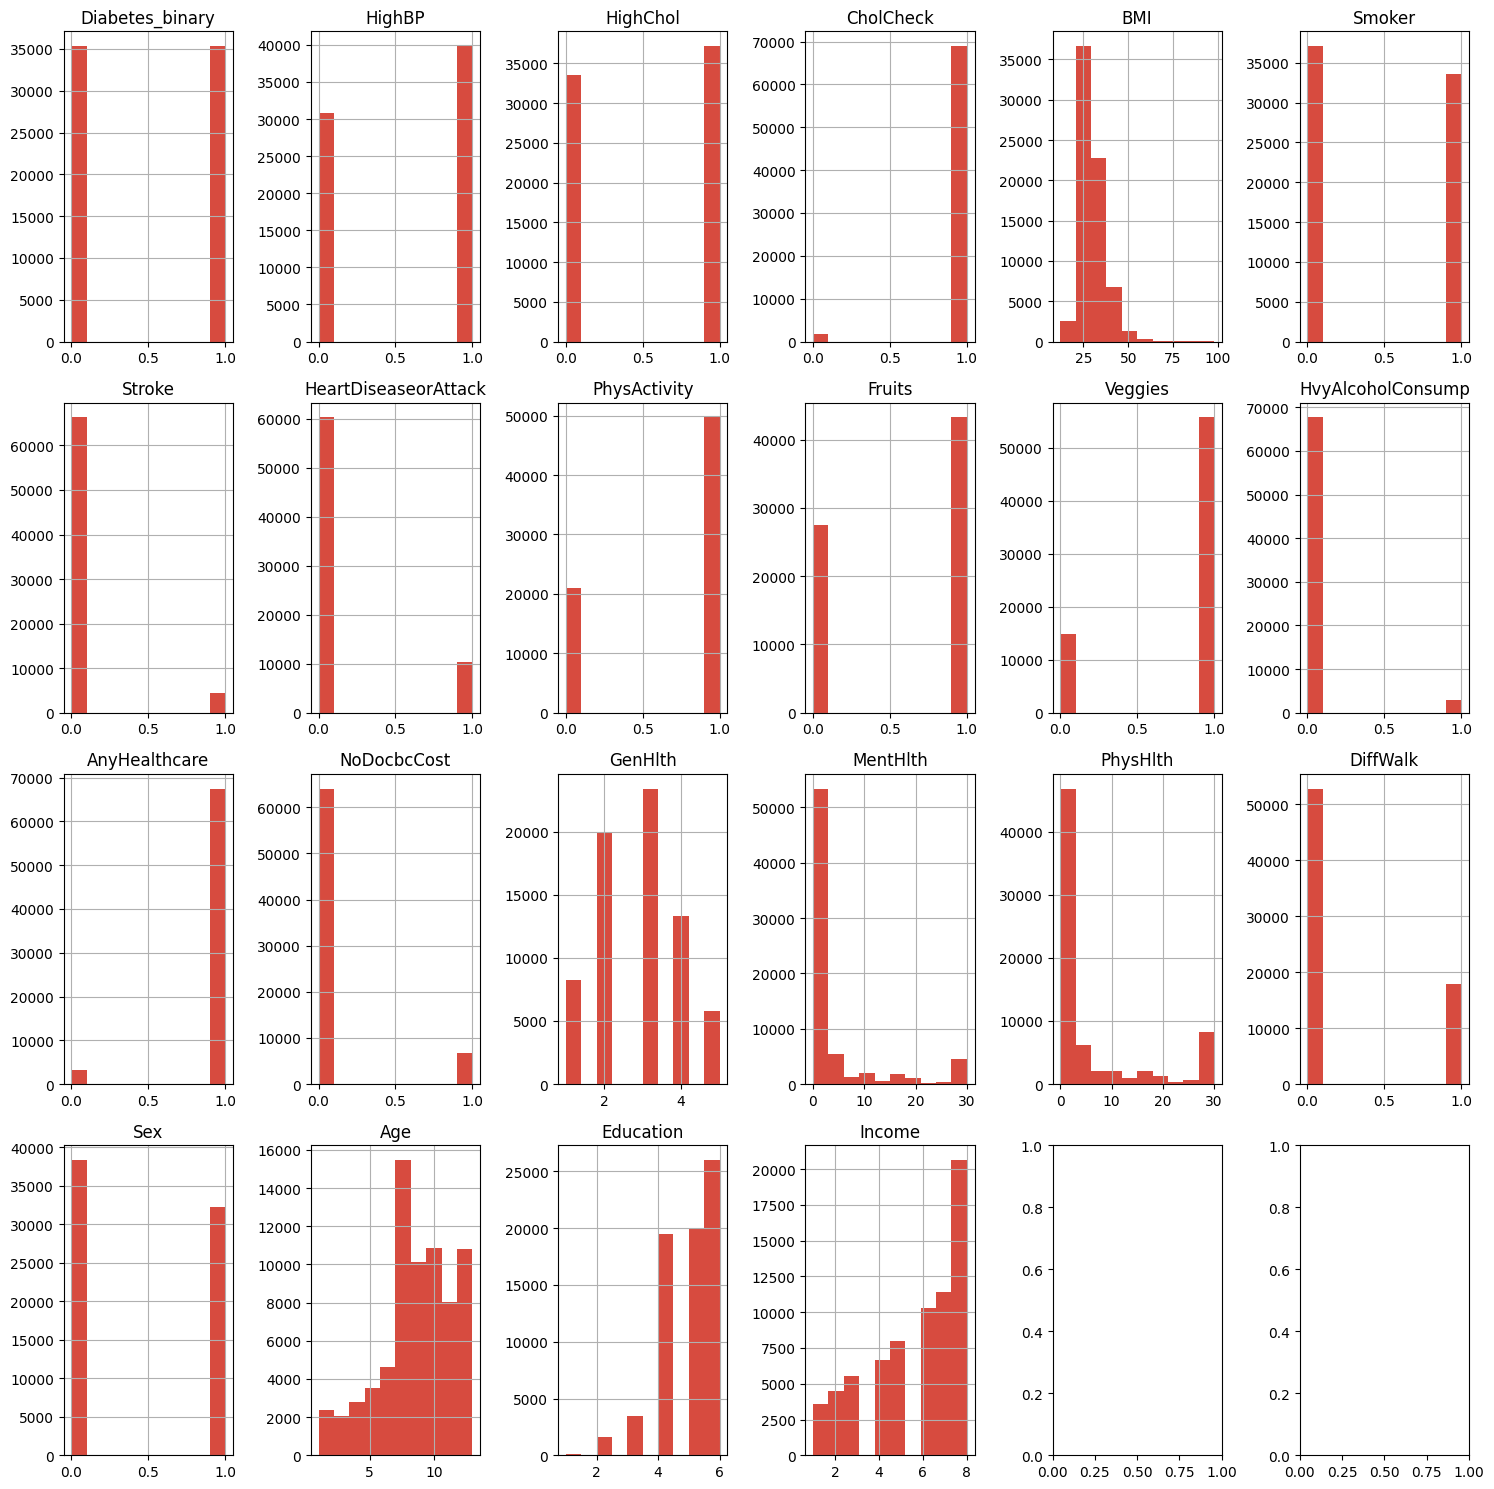

In [90]:
# Univariate analysis

col = [x for x in df.columns]
num_columns = len(col)

# Define the grid size for the subplots
n_rows = int(num_columns ** 0.5)
n_cols = int(np.ceil(num_columns / n_rows))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot each histogram in a subplot
for i, x in enumerate(col):
    df.hist(column=x, ax=axes[i], figsize=(4, 4), color=c1)

plt.tight_layout()

Our univariate analysis revealed a balanced population with minimal outliers.

# EDA - Comparing negative and positive to diabetes populations

In [4]:
# Spliting the population in 2 groups:

# positive to diabetes
df_positive = df.loc[df['Diabetes_binary'] == 1]

# negative to diabetes
df_negative = df.loc[df['Diabetes_binary'] == 0]

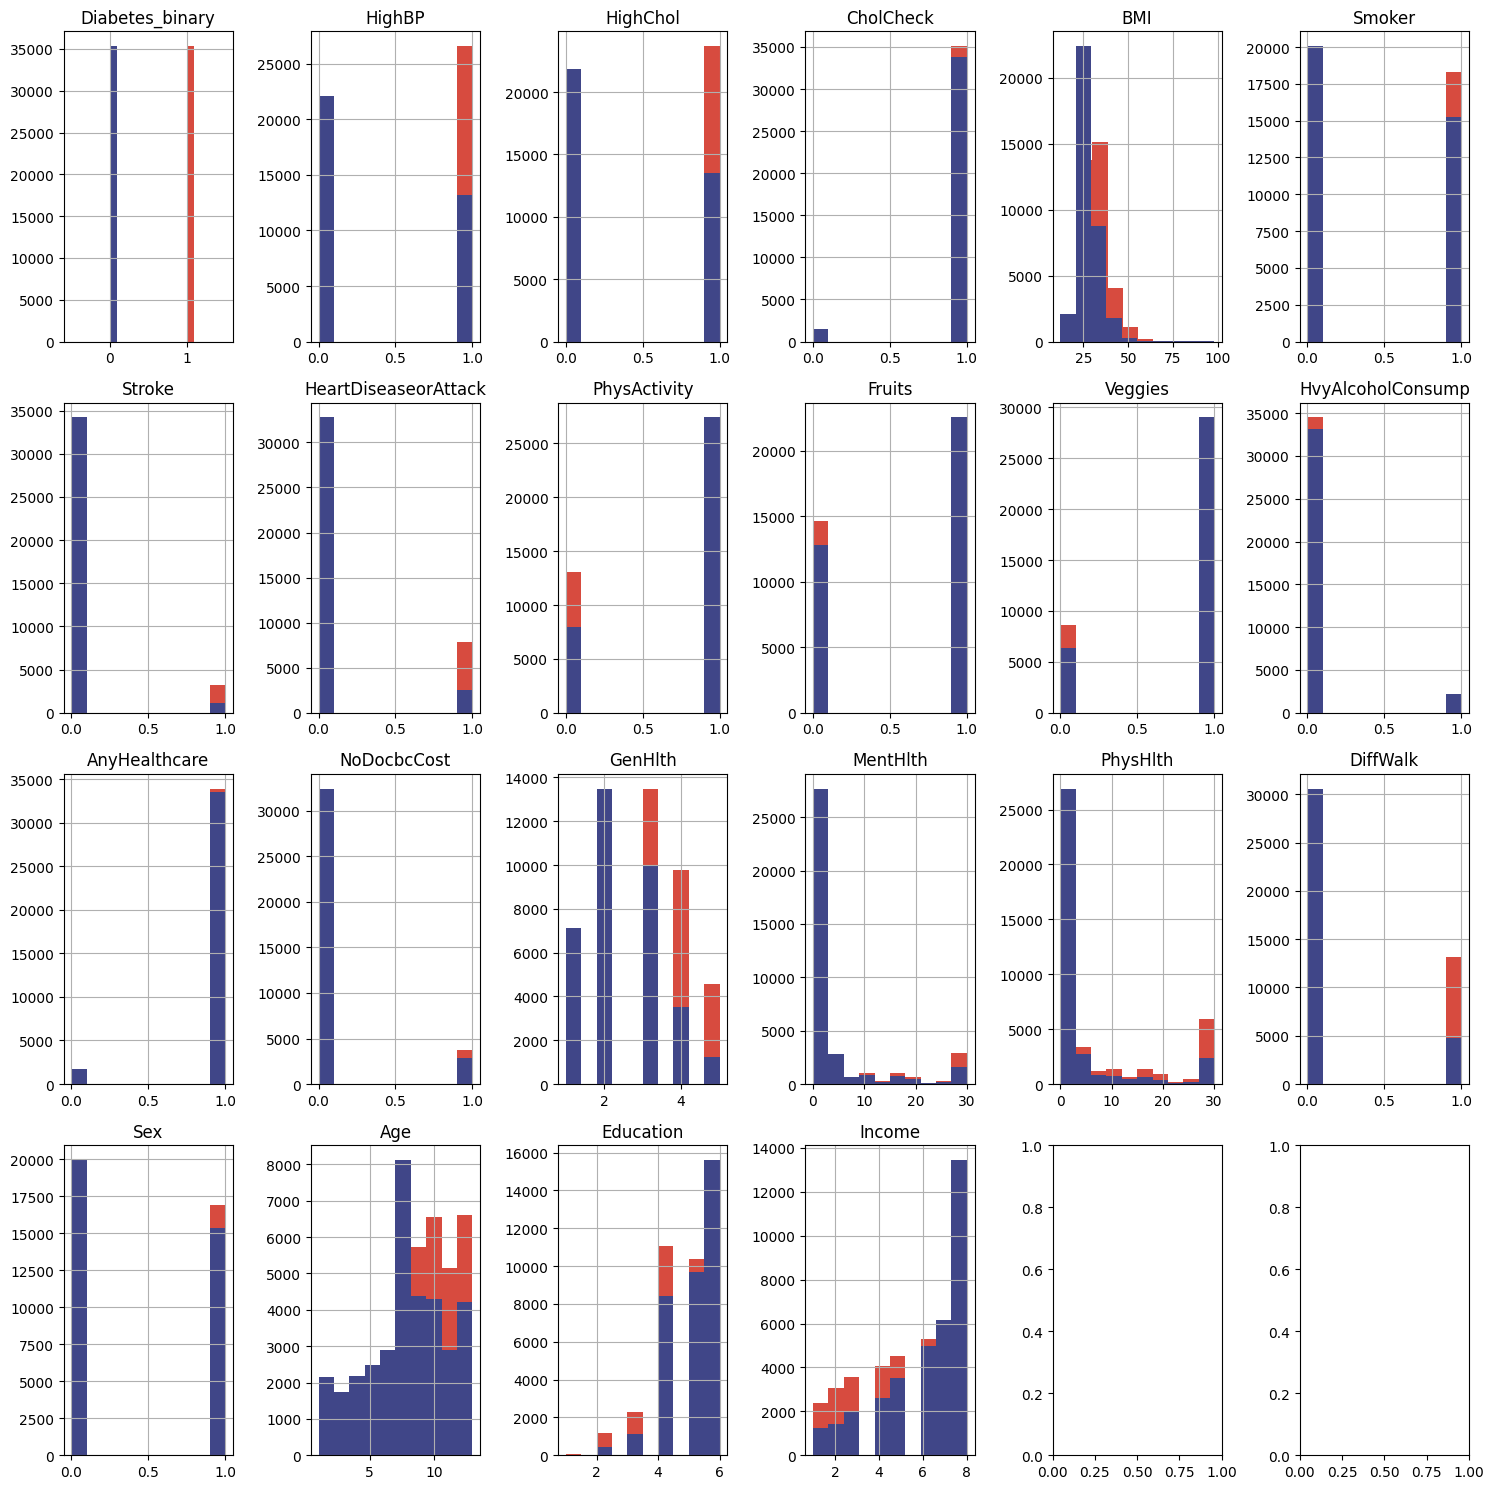

In [93]:
# Univariate check comparing diabetes's positive and negative populations:

col = [x for x in df.columns]
num_columns = len(col)

# Define the grid size for the subplots
n_rows = int(num_columns ** 0.5)
n_cols = int(np.ceil(num_columns / n_rows))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.flatten()

# Plot each histogram in a subplot
for i, x in enumerate(col):
    df_positive.hist(column=x, ax=axes[i], figsize=(4, 4), alpha=1, color=c1)
    df_negative.hist(column=x, ax=axes[i], figsize=(4, 4), alpha=1, color=c2)

plt.tight_layout()

By comparing the distributions of the two population (negative vs positive to diabetes), we can already note features with notable differences:
- HighBP
- HighCol
- BMI
- Smoker
- HeartDiseaseorAttack
- PhysActivity
- GenHlth
- PhysHlth
- DiffWalk
- Age
- Education
- Income

These are interesting first outputs for our feature selection.
However, we want to refine these rough observations by checking potential correlation between our features.


# EDA - Features correlation

In [65]:
df_corr = df.corr()

<Axes: >

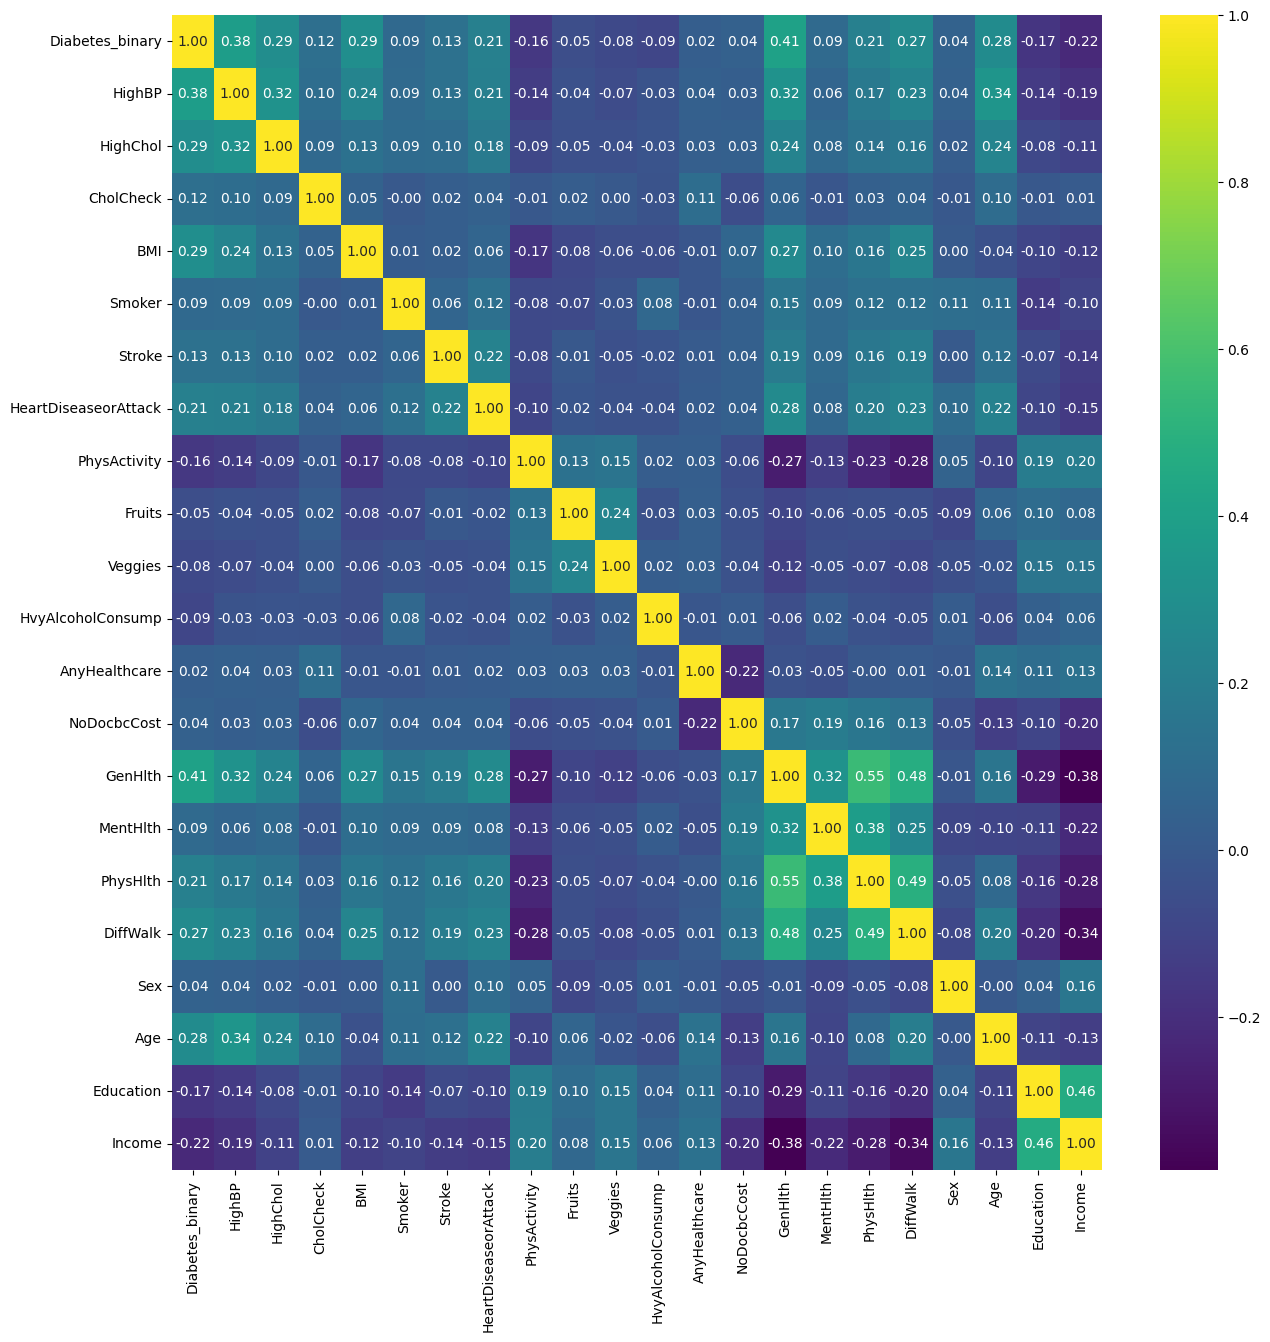

In [70]:
plt.figure(figsize=(15, 15))

sns.heatmap(data=df_corr, fmt='.2f', annot=True, cmap='viridis')

Most features do not display very strong correlation,
however some are noticeable and confirm our previous observation when comparing postive and negative populations.<br>
Correlation > 20 or < -20:
- Income
- Age
- DiffWalk
- PhysHlth
- GenHlth
- HeatDiseaseOrAttack
- BMI
- HighCol
- HighBP


We observe distinct metrics, but it's challenging to determine whether they represent conditions that lead to the disease, symptoms or effects of the disease, or both.

The features can be categorized as follows:

Physiological Conditions: BMI, HighCholesterol
Socio-economic Conditions: Income, Age, Difficulty Walking
Symptoms: Heart Disease or Attack, High Blood Pressure, Physical Health, General Health
Overall, we cannot definitively conclude that these correlations are causes of a diabetes diagnosis. However, to further explore and refine these observations, we could apply a combination of statistical and machine learning models to investigate these features as potential risk factors for diabetes.

# Chi2 feature selection

Making use of a statistical model to operate a first features selection.

In [5]:
# Chi2 feature selection
# Preparing features

df_chi = df.drop(['HighBP', 'Stroke', 'HeartDiseaseorAttack', 'MentHlth', 'PhysHlth', 'GenHlth',
                  'NoDocbcCost', 'CholCheck', 'AnyHealthcare'], axis=1)

In [6]:
X = df_chi.drop('Diabetes_binary', axis=1)
y = df_chi['Diabetes_binary']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

K = 8
chi2_selector = SelectKBest(score_func=chi2, k=K)
X_Kbest = chi2_selector.fit_transform(X_scaled, y)

chi2_scores = chi2_selector.scores_
selected_features = X.columns

chi2_results = pd.DataFrame({'features' : selected_features,
              'scores' : chi2_scores}).sort_values(by='scores', ascending=False)

Text(0, 0.5, 'Chi2 scores')

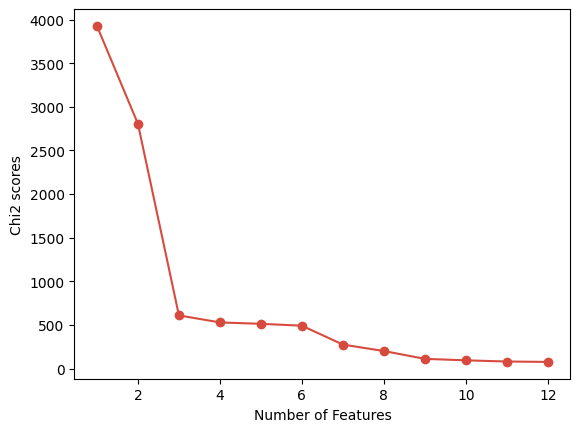

In [94]:
# Plot the scores to find the "elbow" to define the definite value of chi2 'k'

sorted_scores = sorted(chi2_scores, reverse=True)

plt.plot(range(1, len(sorted_scores)+1), sorted_scores, marker='o', color=c1)
plt.xlabel('Number of Features')
plt.ylabel('Chi2 scores')

In [7]:
# From here, we could decide to retain either the first 6 or 8 features
# We decided on being conservative and to preserve 8 features, since we will refine our Chi2 results later on

chi2_results_select = chi2_results.iloc[1:9]

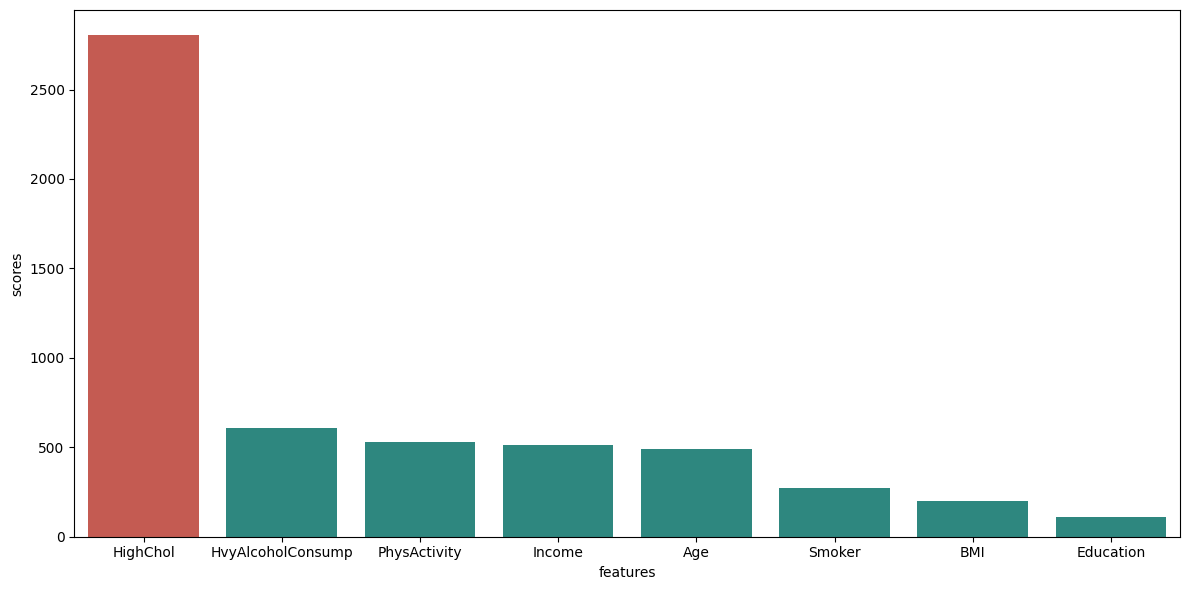

In [97]:
top_1_features = chi2_results_select.head(1)

temp_res_col = [c1 if feature in top_1_features.values else c3 for feature in chi2_results_select['features']]

plt.figure(figsize=(12, 6))
sns.barplot(data=chi2_results_select, x='features', y='scores', hue='features', palette=temp_res_col, legend=False)
plt.tight_layout()

# Random Forest Features Selection

Refine our Chi2 features selection by plugging its outputs to a Random Forest features selection model

In [8]:
# train model

X_train, X_test, y_train, y_test = train_test_split(X_Kbest, y, test_size=0.2, random_state=32)

random_forest_model = RandomForestClassifier(n_estimators=50, random_state=32)

random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6717589645660937
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.67      7096
           1       0.67      0.67      0.67      7043

    accuracy                           0.67     14139
   macro avg       0.67      0.67      0.67     14139
weighted avg       0.67      0.67      0.67     14139

Confusion Matrix:
[[4804 2292]
 [2349 4694]]


In [52]:
# grid_search for optimizing model's parameters

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, cv=5, n_jobs=-2, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters found by GridSearchCV:")
print(grid_search.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters found by GridSearchCV:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [9]:
# Checking our model with the optimized hyperparameters

random_forest_model = RandomForestClassifier(n_estimators=200,
                                             random_state=32,
                                             min_samples_leaf = 2,
                                             min_samples_split = 10,
                                             max_depth =10,
                                             max_features ='sqrt')

random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.717094561142938
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.67      0.70      7096
           1       0.70      0.76      0.73      7043

    accuracy                           0.72     14139
   macro avg       0.72      0.72      0.72     14139
weighted avg       0.72      0.72      0.72     14139

Confusion Matrix:
[[4760 2336]
 [1664 5379]]


In [10]:
# Features selection

# Retrain model on full data set with best hyperparameters
random_forest_model_final = RandomForestClassifier(n_estimators=200,
                                             random_state=32,
                                             min_samples_leaf = 2,
                                             min_samples_split = 10,
                                             max_depth =10,
                                             max_features ='sqrt')
random_forest_model_final.fit(X_Kbest, y)

features_importances = random_forest_model_final.feature_importances_

selector = SelectFromModel(random_forest_model_final, threshold="mean", prefit=True)
X_final = selector.transform(X_Kbest)

In [71]:
print(f"Original number of features after Chi2: {X_Kbest.shape[1]}")
print(f"Number of features selected by Random Forest: {X_final.shape[1]}")

Original number of features after Chi2: 8
Number of features selected by Random Forest: 4


In [11]:
selected_features_2 = [x for x in chi2_results_select['features']]
df_features_final = pd.DataFrame({'features' : selected_features_2,
                                  'scores' : features_importances}).sort_values(by='scores', ascending=False)

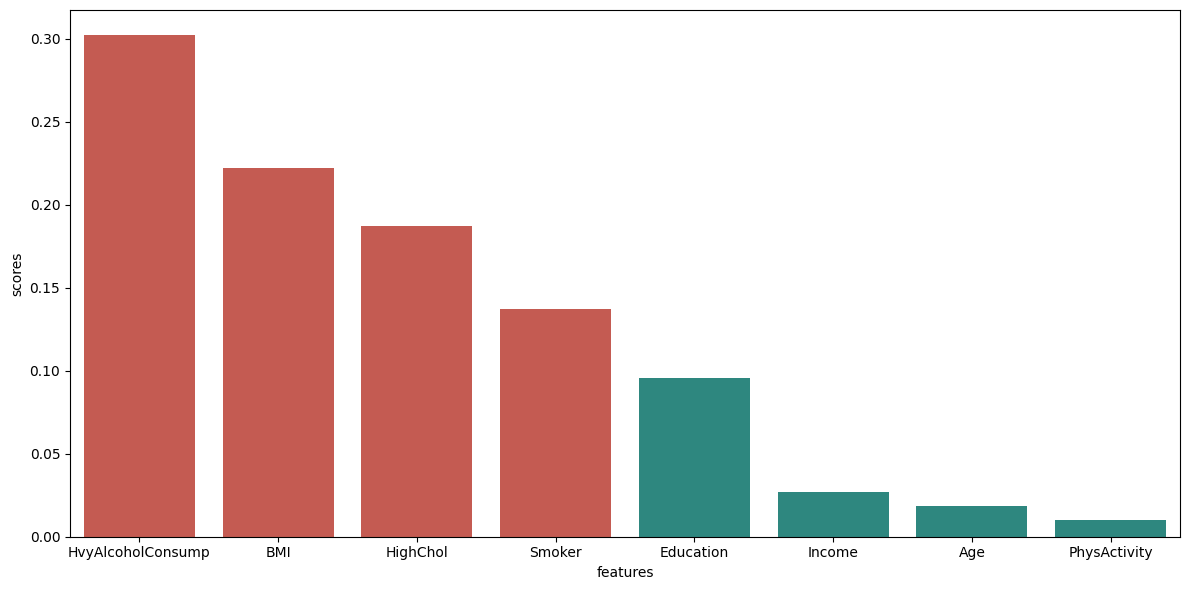

In [12]:
top_4_features = df_features_final['features'].head(4)
colors = [c1 if feature in top_4_features.values else c3 for feature in df_features_final['features']]

plt.figure(figsize=(12, 6))
sns.barplot(data=df_features_final, x='features', y='scores', hue='features', palette=colors, legend=False)
plt.tight_layout()

In red: final 4 features to consider according to our Random Forest model<br>
In grey: other features to consider to a lesser degree of importance

# Addendum: possible false negative and limit

Given the identified risk factors for diabetes, we briefly examined the population that tested negative but lacks access to healthcare and didn't have a medical consultation within the past year due to cost. <br>
We aimed to determine if this group might be at risk or could include false negatives.

In [13]:
# Scale values first

df_positive_scaled = pd.DataFrame(scaler.fit_transform(df_positive), columns=df_positive.columns)
df_negative_scaled = pd.DataFrame(scaler.fit_transform(df_negative), columns=df_negative.columns)

In [14]:
# Filter for the population of interest

df_positive_mean = df_positive_scaled[['HvyAlcoholConsump', 'BMI', 'HighChol', 'Smoker']].mean().reset_index().rename(columns={'index' : 'features',
                                               0 : 'means_pos'})

df_negative_false = df_negative_scaled.loc[(df_negative['NoDocbcCost'] == 1) & (df_negative['AnyHealthcare']==0)]
df_neg_false = df_negative_false[['HvyAlcoholConsump', 'BMI', 'HighChol', 'Smoker']].mean().reset_index().rename(columns={'index' : 'features',
                                               0 : 'means_neg_false'})

df_negative_true = df_negative_scaled.loc[(df_negative['NoDocbcCost'] == 0) & (df_negative['AnyHealthcare']==1)]
df_neg_true = df_negative_true[['HvyAlcoholConsump', 'BMI', 'HighChol', 'Smoker']].mean().reset_index().rename(columns={'index' : 'features',
                                               0 : 'means_neg_true'})

In [15]:
df_confusion = df_positive_mean.merge(df_neg_false, on='features', how='inner')
df_confusion = df_confusion.merge(df_neg_true, on='features', how='inner')
df_confusion

,features,means_pos,means_neg_false,means_neg_true
0,HvyAlcoholConsump,0.023539,0.085987,0.060578
1,BMI,0.222871,0.198434,0.182089
2,HighChol,0.670118,0.358280,0.384225
3,Smoker,0.518220,0.549363,0.421970


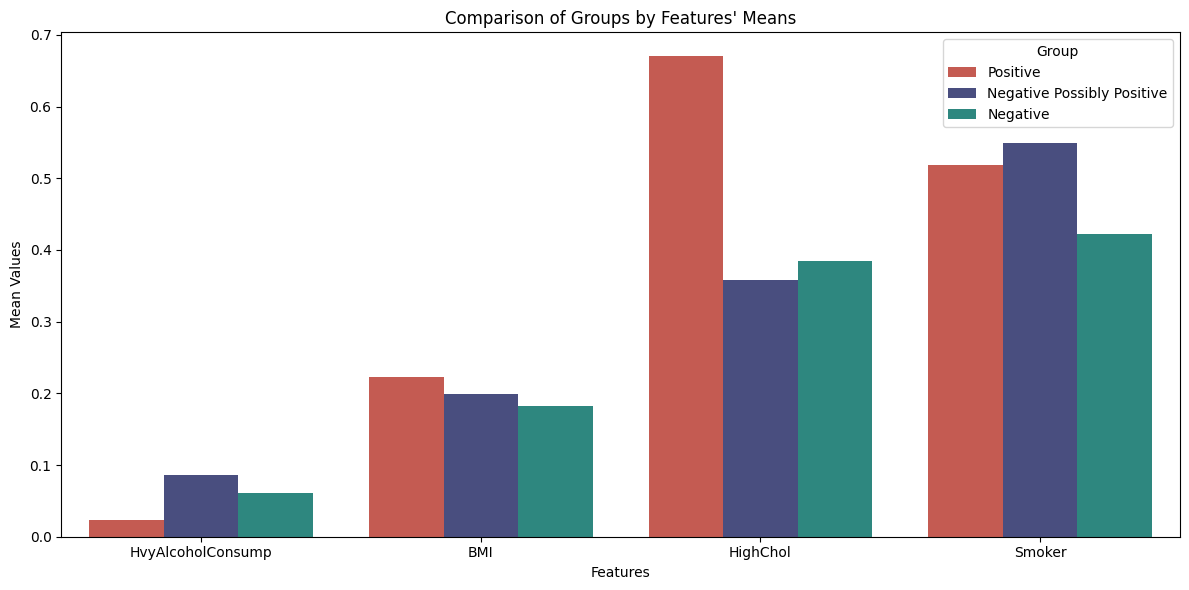

In [20]:
df_melted = df_confusion.melt(id_vars='features', value_vars=['means_pos', 'means_neg_false', 'means_neg_true'],
                              var_name='group', value_name='value')

colors2 = [c1, c2, c3]

# Plot with seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='features', y='value', hue='group', palette=colors2)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(title='Group', labels=['Positive', 'Negative Possibly Positive', 'Negative'], handles=handles)
plt.xlabel('Features')
plt.ylabel('Mean Values')
plt.title("Comparison of Groups by Features' Means")

plt.tight_layout()
plt.show()

Heavy alcohol consumption is an intriguing possible factor of diabetes in our data, as it correlates negatively with a positive diagnosis to diabetes.
However, this could be due to change of behavior of people with diabetes: for health reason, once positively diagnosed, they would reduce their alcohol consumption.
A similar logic could be applied to smoking habit: people tested positive smokes less than people tested negatively but at risk of diabetes due to lack of medical consultation and insurance.

<Axes: xlabel='group', ylabel='value'>

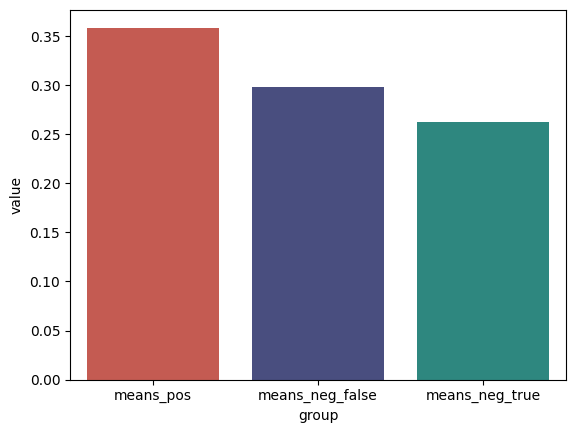

In [21]:
# Making a ratio of the metrics to have a better view of the risk by the population tested negatively to diabetes

ratio_confusion = df_melted.groupby('group')['value'].mean().reset_index()
ratio_confusion = ratio_confusion.sort_values(by='value', ascending=False)


sns.barplot(data=ratio_confusion, x='group', y='value', hue=['Positive', 'Negative Possibly Positive', 'Negative'], palette=colors2, legend=False)


Overall, if we analyze the features most likely to lead to diabetes and calculate their mean for the positive diabetes population as a benchmark, then compare this benchmark to the negative population without access to healthcare and who didn't see a doctor due to cost in the last 12 months, we observe that this group is at a higher risk of contracting diabetes compared to the rest of the negatively tested population who have access to healthcare. This suggests that some individuals in this at-risk group might be false negatives, undiagnosed due to a lack of medical consultation.